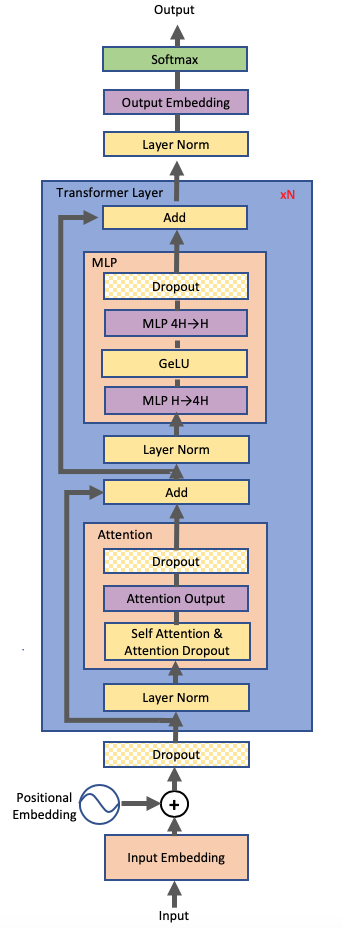

1. text를 tokenization 해줌 <br>
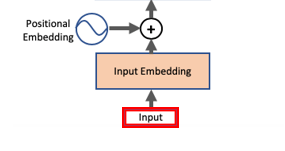

- GPT의 Pre-Training은 Unsupervised learning이기 때문에 input과 label이 유사 <br>
- GPT에는 window_size라는 변수가 있는데 이는 한 input의 토큰 갯수를 의미<br>
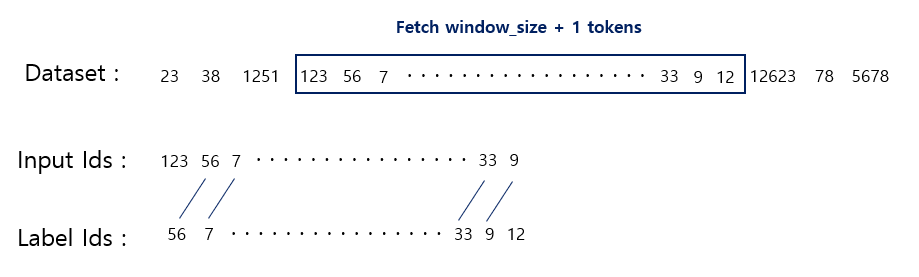<br>

In [3]:
import h5py
import random
from torch.utils.data import Dataset

class GPTDataset(Dataset):
    def __init__(self, dataset_path: str, seq_len: int, window_size: int, rng: random.Random):
        self.dataset = h5py.File(dataset_path, 'r')['token_ids']
        self.seq_len = seq_len
        self.window_size = window_size
        self.rng = rng
        self.size = len(self.dataset)

    def __len__(self):
        return self.size
    
    def __getitem__(self.idx):
        start_point = self.rng.randint(0, self.size) # 0부터 self.size까지 중 랜덤
        end_point = min(start_point + (window_size + 1), self.size) # 최소 start_point에서 window_size+1만큼 더한거부터 self.size까지
        window = self.dataset[start_point:end_point]

        input_ids = window[:-1]
        label_ids = window[1:]
        return input_ids, label_ids

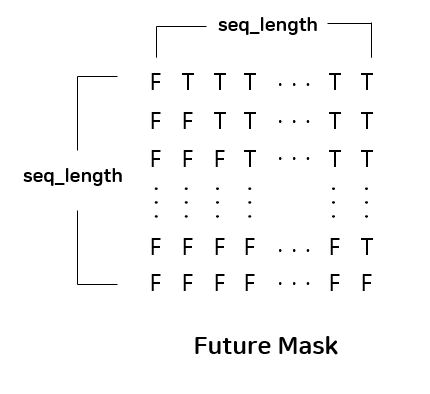

### getitem 함수
- start_point : 0 ~ 데이터셋 길이 사이의 임의의 시작점을 고른다.
- end_point : 한 sample의 끝점을 고른다.
- window : window size + 1개의 연속된 토큰을 슬라이싱한다.
- input_ids : 첫 번째 토큰부터 window_size개 = Input Ids
- label_ids : 두 번째 토큰부터 window_size개 = Label Ids

모델에 실제로 input으로 들어가게 되는 input ids와 label ids는 (batchsize, seq_length)의 shape을 가짐<br>
모델에는 input ids가 들어가고 출력된 logits과 label ids와 비교하게 된다.<br>
seq_length는 window_size와 동일 

In [ ]:
import torch

def create_future_mask(x: torch.Tensor, offset: int = 0) -> torch.Tensor:
    seq_len = x.size(-1)

    # Create shifted upper triangular matrix
    future = torch.ones((seq_len, seq_len), dtype = torch.bool, device = x.device)
    future = future.triu(1)

    future_mask = future.view((1, ) * (x.ndim - 1) + future.size())

    return future_mask.expand(x.shape + future_mask.shape[-1:]) # (b, s, s) 

2. Embedding, Dropout <br>
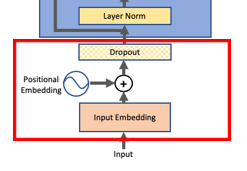

- Token Embedding(token들의 차원을 축소하는 과정) : Token Id의 차원은 vocab 개수 <br>
Vocab이 N개이면 Token Id는 0 ~ N-1의 정수가 될 수 있다. <br>
즉, 0 ~ N-1의 정수를 hidden_size의 벡터로 바꾸는 과정 <br>
hidden_size는 Embedding 차원이며 Token Embedding을 거치면 input ids(token id의 배열)이 (batch_size, seq_length, hidden_size)의 shape을 가지게 됨
- Position Embedding : GPT의 input에는 해당 token의 위치가 어디인지에 대한 정보가 없기에 postion embedding으로 위치 정보를 추가해줌 <br>
position embedding 후에도 (batch_size, seq_length, hidden_size)의 shape의 벡터를 얻음
- Dropout : Dropout 과정을 거쳐 Masked Attention Layer에 들어갈 input을 만든다.

In [ ]:
import torch.nn as nn

token_embeddings = nn.Embedding(vocab_size, hidden_size)
position_embeddings = nn.Embedding(seq_len, hidden_size)

def position_embed(input_ids, position_embeddings):

    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype = torch.long, device = input_ids.device)
    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

    position_embedding_vector = position_embeddings(position_ids)

    return position_embedding_vector

drop = nn.Dropout(0.1)
final_embe_vector = drop(token_embed_vector + position_embed_vector)